# Week 4 - Function 5 ((23DP, 4D))

# Setup

In [1]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.svm import SVC, SVR
from scipy.stats.qmc import LatinHypercube
from ipywidgets import interact, FloatSlider

from utils.plotting_utils import (
    plot_4D_initial_data,
    plot_output_outliers,
    plot_bar_diff,
    plot_log_transform,
    plot_nd_mean_uncertainty_slice,
    plot_nd_svm_analysis_slice,
    plot_nd_acquisition_comparison_slice
)

# Plan
We now have ((23, 4)) - 23DP & 4D that can be found `./data/week_4/function_5/`.

1. Load data
2. Preprocessing (QuantileTransformer + Log Transform)
3. Build probabilistic Models (2-GP ensemble: QT + log-space)
4. SVM Analysis (Classifier + SVR surrogates)
5. Acquisition Function (SVM-constrained UCB, 2-GP ensemble)

# 1. Load data

In [2]:
X_train_raw = np.load(r"./data/week_4/function_5/inputs.npy")
y_train_raw = np.load(r"./data/week_4/function_5/outputs.npy")
print(f"Shape: X={X_train_raw.shape}, y={y_train_raw.shape}")
print(f"X range: [{X_train_raw.min():.4f}, {X_train_raw.max():.4f}]")
print(f"y range: [{y_train_raw.min():.2e}, {y_train_raw.max():.2e}]")

Shape: X=(23, 4), y=(23,)
X range: [0.0382, 0.9576]
y range: [1.13e-01, 1.63e+03]


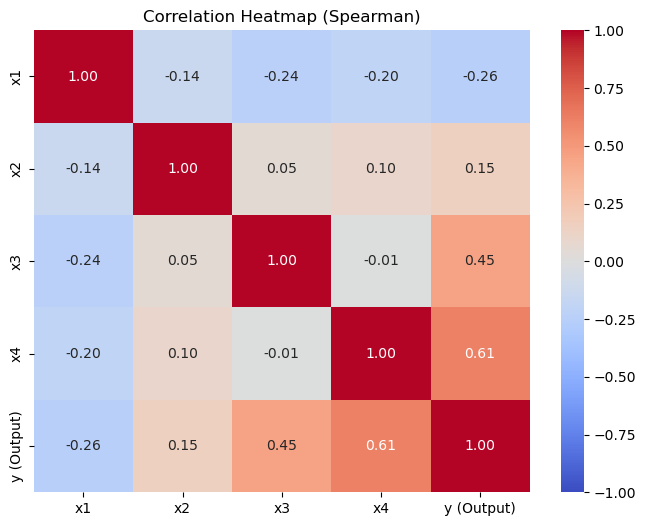

Generating Pairplot...


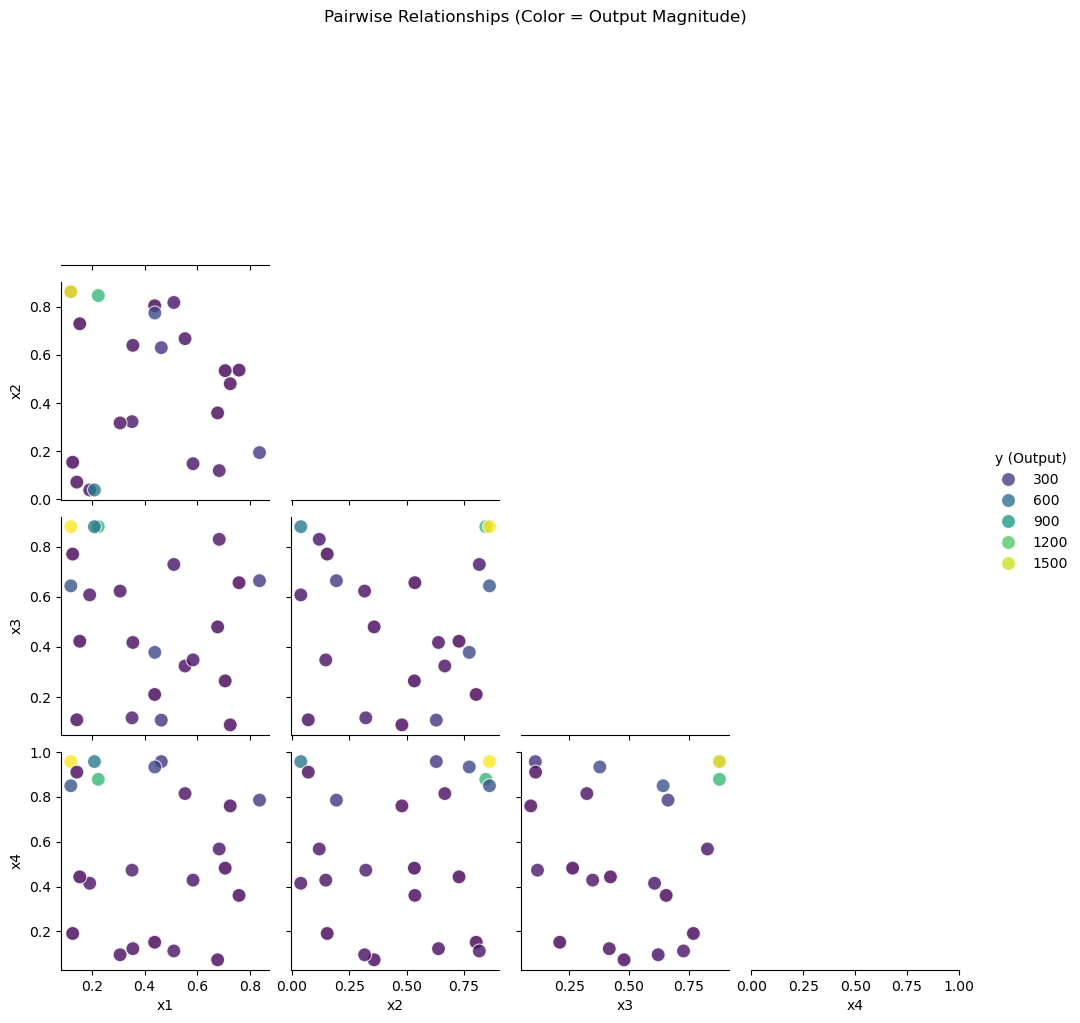

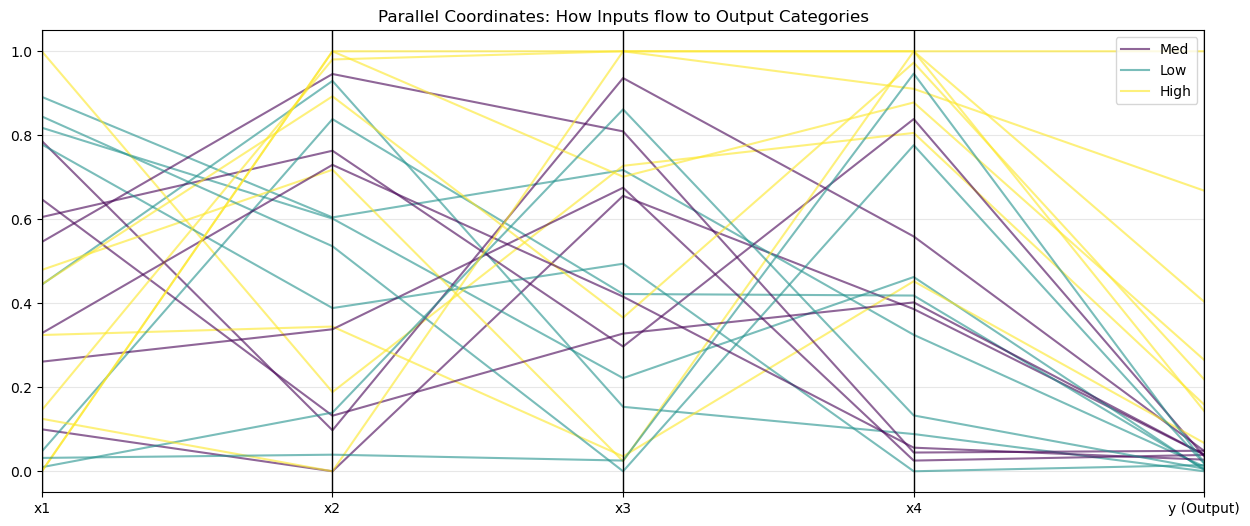

In [3]:
plot_4D_initial_data(X_train_raw, y_train_raw, "Step1: Data points", f"""
DATA SUMMARY
{'='*80}
Points: {len(X_train_raw)}
Input shape: {X_train_raw.shape}
Output shape: {y_train_raw.shape}

CURRENT BEST
{'='*80}
Current best: {np.max(y_train_raw)}
At input: {X_train_raw[np.argmax(y_train_raw)]}
""")

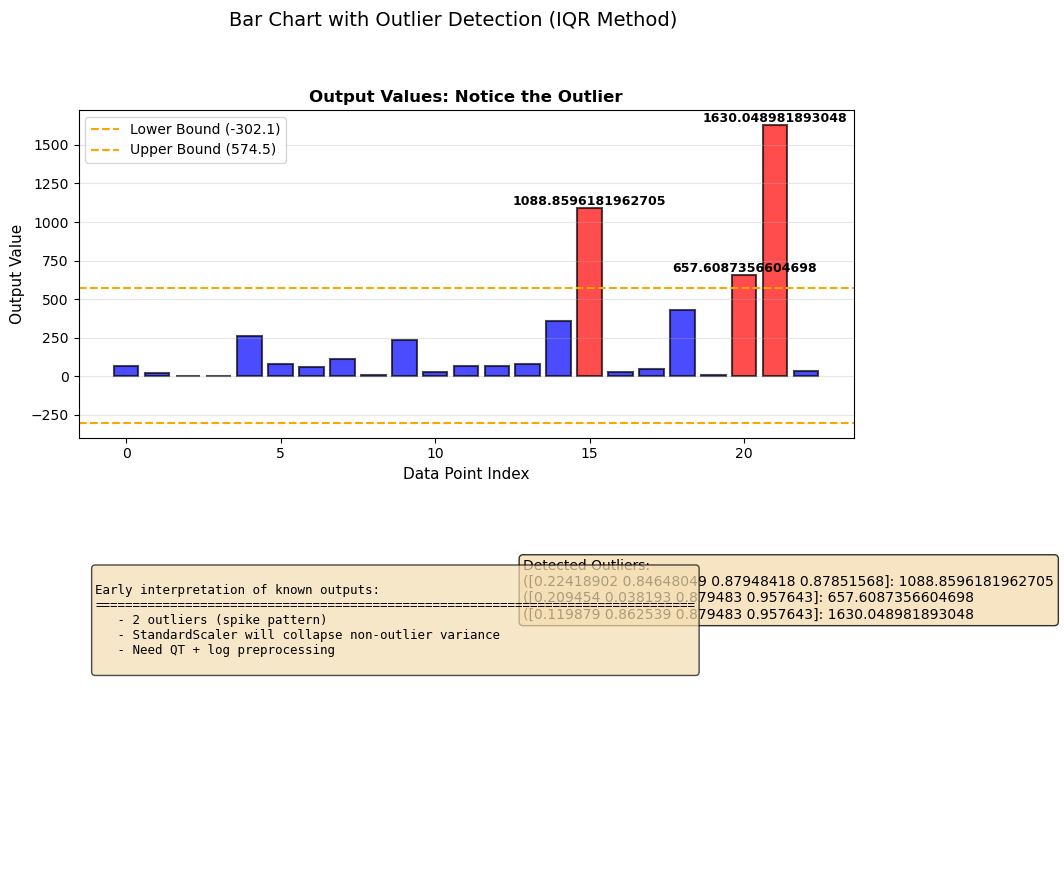

In [4]:
plot_output_outliers(X_train_raw, y_train_raw, "Bar Chart with Outlier Detection (IQR Method)", f"""
Early interpretation of known outputs:
{'='*80}
   - 2 outliers (spike pattern)
   - StandardScaler will collapse non-outlier variance
   - Need QT + log preprocessing
""")

# 2. Preprocessing

The output data contains significant outlier spikes. `StandardScaler` collapses the variance of non-outlier points. We use:
- **QuantileTransformer**: rank-based, spreads data uniformly
- **log10 transform**: models magnitude differences for positive-shifted points

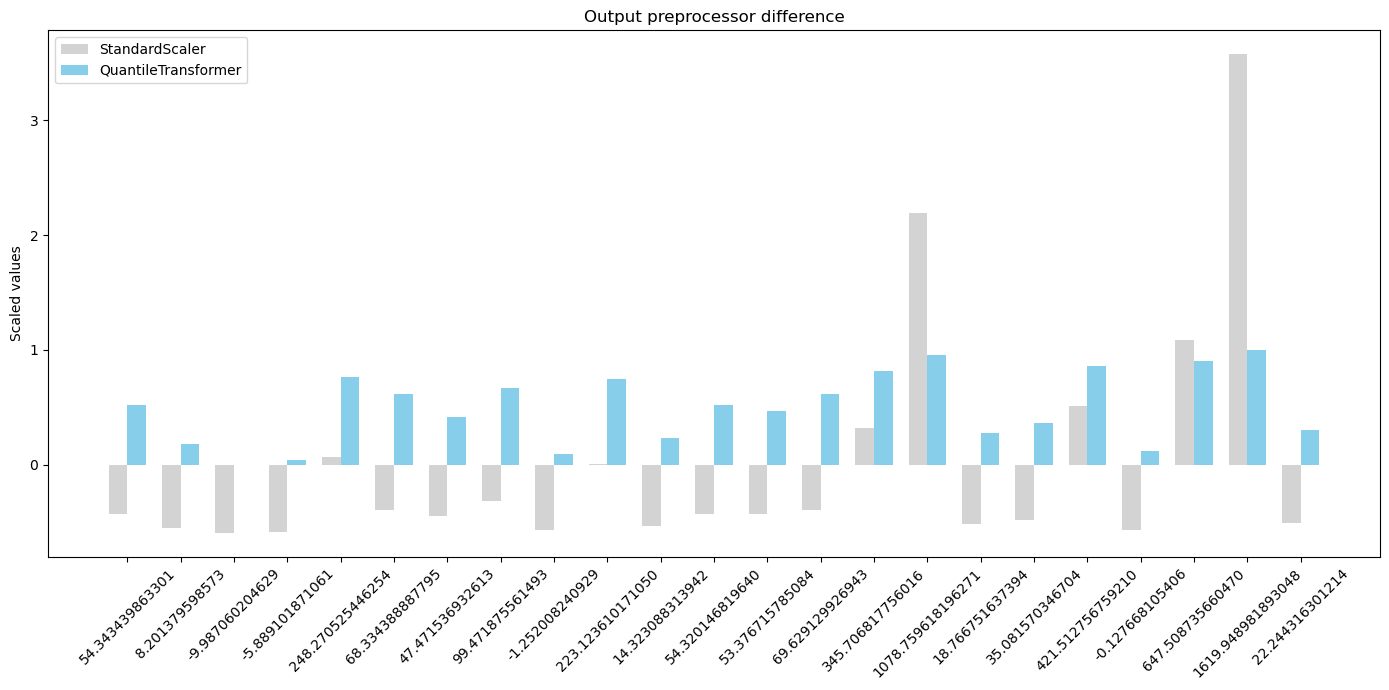

Total points: 23
QT range: [0.0, 1.0]
Best point: X=[0.119879 0.862539 0.879483 0.957643], y=1.63e+03


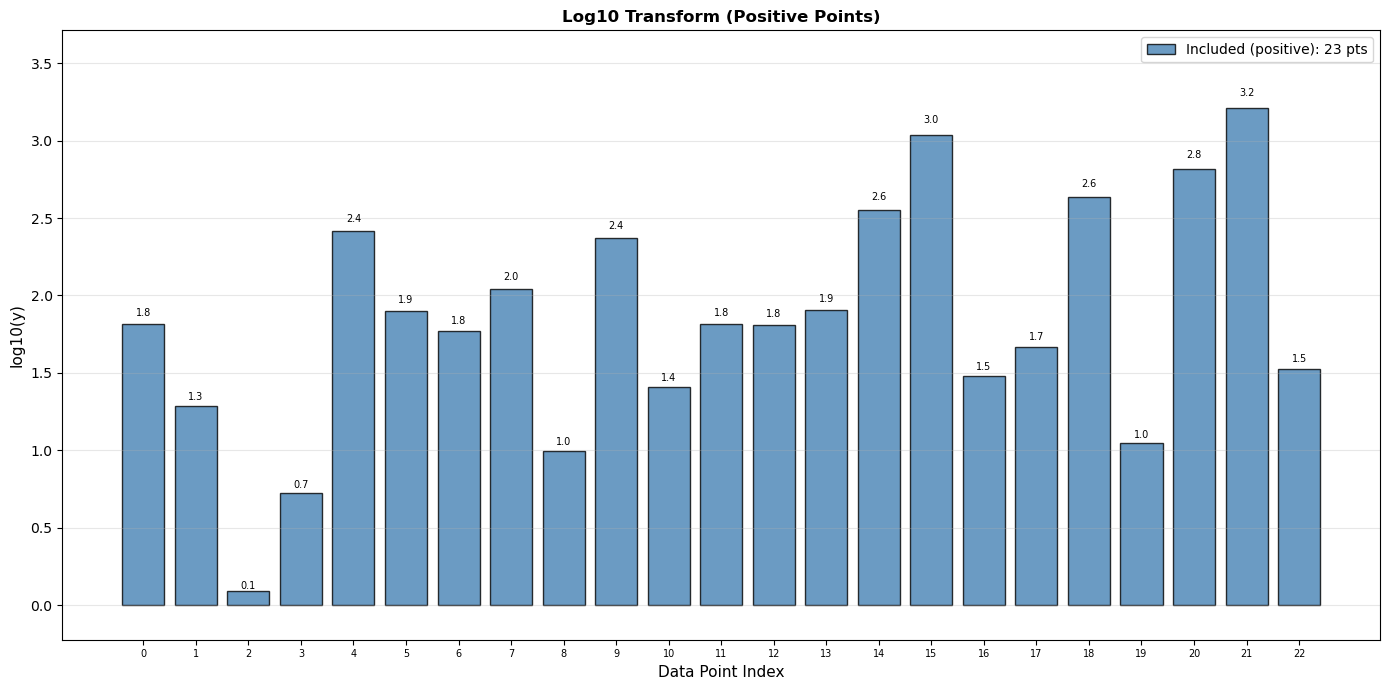


Log shift constant: 1.11
Positive points after shift: 23/23


In [5]:
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train_raw)

from sklearn.preprocessing import StandardScaler
scaler_ss = StandardScaler()
y_ss = scaler_ss.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

scaler_qt = QuantileTransformer(n_quantiles=len(y_train_raw)-1, output_distribution='uniform')
y_qt = scaler_qt.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

plot_bar_diff(y_train_raw, y_ss, y_qt, 'StandardScaler', 'QuantileTransformer',
              'Scaled values', 'Output preprocessor difference')

print(f"Total points: {len(X_train)}")
print(f"QT range: [{y_qt.min():.1f}, {y_qt.max():.1f}]")
print(f"Best point: X={X_train_raw[np.argmax(y_train_raw)]}, y={y_train_raw.max():.2e}")

# Log transform with shift
log_shift_constant = abs(y_train_raw.min()) + 1.0
y_train_raw_shifted = y_train_raw + log_shift_constant
pos_mask = y_train_raw_shifted > 0
X_train_pos = X_train[pos_mask]
y_log_pos = np.log10(y_train_raw_shifted[pos_mask])

plot_log_transform(y_train_raw, y_log_pos, pos_mask)

print(f"\nLog shift constant: {log_shift_constant:.2f}")
print(f"Positive points after shift: {pos_mask.sum()}/{len(y_train_raw)}")

# 3. Build probabilistic Models (2-GP ensemble)

- **gp_qt**: GP on QuantileTransformer output (all points) — models rank structure
- **gp_log**: GP on log10 output (positive points) — models magnitude differences

In [6]:
gp_qt = GaussianProcessRegressor(
    kernel=ConstantKernel(0.25, (1e-3, 10)) * Matern(
        length_scale=[0.5]*4, nu=2.5,
        length_scale_bounds=(0.05, 5.0)
    ),
    alpha=0.01, normalize_y=True,
    n_restarts_optimizer=30
)

gp_log = GaussianProcessRegressor(
    kernel=ConstantKernel(1.0, (1e-3, 1e3)) * Matern(
        length_scale=[0.5]*4, nu=2.5,
        length_scale_bounds=(1e-3, 10.0)
    ),
    alpha=1e-4, normalize_y=True,
    n_restarts_optimizer=50
)

gp_qt.fit(X_train, y_qt)
gp_log.fit(X_train_pos, y_log_pos)

print(f"GP(QT) kernel: {gp_qt.kernel_}")
print(f"GP(log) kernel: {gp_log.kernel_}")

# Feature importance from ARD length scales
for name, gp in [('GP(QT)', gp_qt), ('GP(log)', gp_log)]:
    ls = gp.kernel_.k2.length_scale
    imp = 1.0 / ls
    imp_norm = imp / imp.sum() * 100
    print(f"\n{name} length scales: {ls}")
    sorted_dims = np.argsort(ls)
    for i in sorted_dims:
        role = 'IMPORTANT' if ls[i] < 1.0 else ('moderate' if ls[i] < 5.0 else 'noise')
        print(f"  x{i+1}: ls={ls[i]:.4f}, importance={imp_norm[i]:.1f}%, {role}")

# Determine plot/slider dims from gp_qt
ls_qt = gp_qt.kernel_.k2.length_scale
sorted_dims = np.argsort(ls_qt)
most_important = sorted_dims[:2]
least_important = sorted_dims[2:]
dim_a, dim_b = most_important[0], most_important[1]
dim_c, dim_d = least_important[0], least_important[1]
print(f"\nPlotting dims: x{dim_a+1}, x{dim_b+1} | Slider dims: x{dim_c+1}, x{dim_d+1}")

GP(QT) kernel: 1.06**2 * Matern(length_scale=[1.1, 0.334, 0.631, 0.327], nu=2.5)
GP(log) kernel: 1.45**2 * Matern(length_scale=[1.8, 0.499, 0.87, 0.568], nu=2.5)

GP(QT) length scales: [1.10414667 0.33420752 0.63102633 0.32670798]
  x4: ls=0.3267, importance=35.8%, IMPORTANT
  x2: ls=0.3342, importance=35.0%, IMPORTANT
  x3: ls=0.6310, importance=18.5%, IMPORTANT
  x1: ls=1.1041, importance=10.6%, moderate

GP(log) length scales: [1.79879333 0.49943194 0.8699565  0.56777529]
  x2: ls=0.4994, importance=36.6%, IMPORTANT
  x4: ls=0.5678, importance=32.2%, IMPORTANT
  x3: ls=0.8700, importance=21.0%, IMPORTANT
  x1: ls=1.7988, importance=10.2%, moderate

Plotting dims: x4, x2 | Slider dims: x3, x1


### Interactive GP Slices

In [7]:
n_grid_2d = 40
x_plot_1 = np.linspace(0, 1, n_grid_2d)
x_plot_2 = np.linspace(0, 1, n_grid_2d)
X1_plot, X2_plot = np.meshgrid(x_plot_1, x_plot_2)

X_train_neg = X_train[~pos_mask]

def plot_gp_slices(fix_c=0.5, fix_d=0.5):
    grid_4d = np.zeros((n_grid_2d * n_grid_2d, 4))
    grid_4d[:, dim_a] = X1_plot.ravel()
    grid_4d[:, dim_b] = X2_plot.ravel()
    grid_4d[:, dim_c] = fix_c
    grid_4d[:, dim_d] = fix_d
    
    fixed_info = f'x{dim_c+1}={fix_c:.2f}, x{dim_d+1}={fix_d:.2f}'
    
    mu_qt, sigma_qt = gp_qt.predict(grid_4d, return_std=True)
    plot_nd_mean_uncertainty_slice(
        X_train, X1_plot, X2_plot,
        mu_qt.reshape(n_grid_2d, n_grid_2d),
        sigma_qt.reshape(n_grid_2d, n_grid_2d),
        dim1_idx=dim_a, dim2_idx=dim_b,
        title_prefix='GP (QT)', fixed_info=fixed_info
    )
    
    mu_log, sigma_log = gp_log.predict(grid_4d, return_std=True)
    plot_nd_mean_uncertainty_slice(
        X_train_pos, X1_plot, X2_plot,
        mu_log.reshape(n_grid_2d, n_grid_2d),
        sigma_log.reshape(n_grid_2d, n_grid_2d),
        dim1_idx=dim_a, dim2_idx=dim_b,
        X_excluded=X_train_neg,
        title_prefix='GP (log)', fixed_info=fixed_info
    )

interact(
    plot_gp_slices,
    fix_c=FloatSlider(min=0, max=1, step=0.05, value=0.5, description=f'x{dim_c+1}'),
    fix_d=FloatSlider(min=0, max=1, step=0.05, value=0.5, description=f'x{dim_d+1}')
)

interactive(children=(FloatSlider(value=0.5, description='x3', max=1.0, step=0.05), FloatSlider(value=0.5, des…

<function __main__.plot_gp_slices(fix_c=0.5, fix_d=0.5)>

# 4. SVM Analysis

- **SVM Classifier**: learns boundary between promising (high output) and unpromising regions
- **SVR surrogates**: independent surface models for visualization

In [8]:
# SVM Classifier
svm_labels = np.zeros(len(y_train_raw), dtype=int)
for i, yi in enumerate(y_log_pos):
    if yi > np.median(y_log_pos):
        svm_labels[np.where(pos_mask)[0][i]] = 1

svm_clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
svm_clf.fit(X_train, svm_labels)

# SVR surrogates
svr_log = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.5)
svr_log.fit(X_train_pos, y_log_pos)

svr_qt = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
svr_qt.fit(X_train, y_qt)

print(f"SVM labels: {svm_labels.sum()} promising, {(1-svm_labels).sum()} not promising")

# Interactive SVM slices
def plot_svm_slices(fix_c=0.5, fix_d=0.5):
    grid_4d = np.zeros((n_grid_2d * n_grid_2d, 4))
    grid_4d[:, dim_a] = X1_plot.ravel()
    grid_4d[:, dim_b] = X2_plot.ravel()
    grid_4d[:, dim_c] = fix_c
    grid_4d[:, dim_d] = fix_d
    
    svm_proba_slice = svm_clf.predict_proba(grid_4d)[:, 1]
    mu_svr_log_slice = svr_log.predict(grid_4d)
    mu_svr_qt_slice = svr_qt.predict(grid_4d)
    
    fixed_info = f'x{dim_c+1}={fix_c:.2f}, x{dim_d+1}={fix_d:.2f}'
    plot_nd_svm_analysis_slice(
        X1_plot, X2_plot,
        svm_proba_slice.reshape(n_grid_2d, n_grid_2d),
        mu_svr_log_slice.reshape(n_grid_2d, n_grid_2d),
        mu_svr_qt_slice.reshape(n_grid_2d, n_grid_2d),
        X_train, X_train_pos, X_train_neg, svm_labels,
        dim1_idx=dim_a, dim2_idx=dim_b, fixed_info=fixed_info
    )

interact(
    plot_svm_slices,
    fix_c=FloatSlider(min=0, max=1, step=0.05, value=0.5, description=f'x{dim_c+1}'),
    fix_d=FloatSlider(min=0, max=1, step=0.05, value=0.5, description=f'x{dim_d+1}')
)

SVM labels: 11 promising, 12 not promising


interactive(children=(FloatSlider(value=0.5, description='x3', max=1.0, step=0.05), FloatSlider(value=0.5, des…

<function __main__.plot_svm_slices(fix_c=0.5, fix_d=0.5)>

# 5. Acquisition Function (SVM-constrained UCB Ensemble)

- **UCB** with kappa=5 for exploration/exploitation balance
- **SVM constraint**: multiply UCB by P(promising) to avoid penalty zones
- **2-GP ensemble**: average normalized constrained UCBs from gp_qt and gp_log
- **LHS candidates**: 10,000 well-distributed points in [0,1]^4

In [9]:
def upper_confidence_bound(mu, sigma, kappa=2.0):
    return mu + kappa * sigma

def constrained_ucb(ucb_vals, svm_proba):
    ucb_shifted = ucb_vals - ucb_vals.min() + 1e-6
    return ucb_shifted * svm_proba

def normalize_01(arr):
    return (arr - arr.min()) / (arr.max() - arr.min() + 1e-10)

# Generate LHS candidates
sampler = LatinHypercube(d=4, seed=42)
X_candidates = sampler.random(n=10_000)

kappa = 5.0

# GP predictions on candidates
mu_gp_qt, sigma_gp_qt = gp_qt.predict(X_candidates, return_std=True)
mu_gp_log, sigma_gp_log = gp_log.predict(X_candidates, return_std=True)

# SVM probability
svm_proba = svm_clf.predict_proba(X_candidates)[:, 1]

# UCB scores
ucb_gp_qt = upper_confidence_bound(mu_gp_qt, sigma_gp_qt, kappa=kappa)
ucb_gp_log = upper_confidence_bound(mu_gp_log, sigma_gp_log, kappa=kappa)

# Constrained UCBs
ucb_c_gp_qt = constrained_ucb(ucb_gp_qt, svm_proba)
ucb_c_gp_log = constrained_ucb(ucb_gp_log, svm_proba)

# Ensemble
ensemble_ucb = (normalize_01(ucb_c_gp_qt) + normalize_01(ucb_c_gp_log)) / 2.0

best_ensemble_idx = np.argmax(ensemble_ucb)
x_next_norm = X_candidates[best_ensemble_idx]
x_next_orig = scaler_X.inverse_transform([x_next_norm])[0]

# Per-surrogate bests
surrogates = {'GP (y_qt)': ucb_c_gp_qt, 'GP (y_log)': ucb_c_gp_log}
best_points = {}
for name, ucb_vals in surrogates.items():
    idx = np.argmax(ucb_vals)
    best_points[name] = {
        'idx': idx, 'norm': X_candidates[idx],
        'orig': scaler_X.inverse_transform([X_candidates[idx]])[0],
        'svm_p': svm_proba[idx]
    }

# Interactive acquisition slices
def plot_acq_slices(fix_c=0.5, fix_d=0.5):
    grid_4d = np.zeros((n_grid_2d * n_grid_2d, 4))
    grid_4d[:, dim_a] = X1_plot.ravel()
    grid_4d[:, dim_b] = X2_plot.ravel()
    grid_4d[:, dim_c] = fix_c
    grid_4d[:, dim_d] = fix_d
    
    mu_qt_s, sigma_qt_s = gp_qt.predict(grid_4d, return_std=True)
    mu_log_s, sigma_log_s = gp_log.predict(grid_4d, return_std=True)
    svm_p_s = svm_clf.predict_proba(grid_4d)[:, 1]
    
    ucb_qt_s = constrained_ucb(upper_confidence_bound(mu_qt_s, sigma_qt_s, kappa), svm_p_s)
    ucb_log_s = constrained_ucb(upper_confidence_bound(mu_log_s, sigma_log_s, kappa), svm_p_s)
    ens_s = (normalize_01(ucb_qt_s) + normalize_01(ucb_log_s)) / 2.0
    
    shape = (n_grid_2d, n_grid_2d)
    fixed_info = f'x{dim_c+1}={fix_c:.2f}, x{dim_d+1}={fix_d:.2f}'
    plot_nd_acquisition_comparison_slice(
        X1_plot, X2_plot,
        {'GP(QT)': ucb_qt_s.reshape(shape), 'GP(log)': ucb_log_s.reshape(shape)},
        svm_p_s.reshape(shape), ens_s.reshape(shape),
        X_train_pos, X_train_neg,
        dim1_idx=dim_a, dim2_idx=dim_b, fixed_info=fixed_info
    )

interact(
    plot_acq_slices,
    fix_c=FloatSlider(min=0, max=1, step=0.05, value=x_next_norm[dim_c], description=f'x{dim_c+1}'),
    fix_d=FloatSlider(min=0, max=1, step=0.05, value=x_next_norm[dim_d], description=f'x{dim_d+1}')
)

# Summary
print(f"{'='*80}")
print(f"RECOMMENDED NEXT POINT (Ensemble of 2 GPs, 10K LHS candidates)")
print(f"{'='*80}")
print(f"  Input (original space): {np.array_str(x_next_orig, precision=6)}")
print(f"  SVM P(promising):       {svm_proba[best_ensemble_idx]:.3f}")

print(f"\nIndividual surrogate suggestions:")
for name, bp in best_points.items():
    print(f"    {name:20s}: {np.array_str(bp['orig'], precision=6)} (SVM P={bp['svm_p']:.3f})")

print(f"\nSanity check - is this a corner?")
for i in range(4):
    at_boundary = x_next_norm[i] < 0.02 or x_next_norm[i] > 0.98
    print(f"  x{i+1} = {x_next_norm[i]:.4f} {'<-- BOUNDARY!' if at_boundary else ''}")

print(f"\nCurrent best: {X_train_raw[np.argmax(y_train_raw)]} (y = {y_train_raw.max()})")

interactive(children=(FloatSlider(value=0.9826500805774578, description='x3', max=1.0, step=0.05), FloatSlider…

RECOMMENDED NEXT POINT (Ensemble of 2 GPs, 10K LHS candidates)
  Input (original space): [0.145479 0.495502 0.865768 0.947503]
  SVM P(promising):       0.516

Individual surrogate suggestions:
    GP (y_qt)           : [0.145479 0.495502 0.865768 0.947503] (SVM P=0.516)
    GP (y_log)          : [0.145479 0.495502 0.865768 0.947503] (SVM P=0.516)

Sanity check - is this a corner?
  x1 = 0.0357 
  x2 = 0.5548 
  x3 = 0.9827 <-- BOUNDARY!
  x4 = 0.9885 <-- BOUNDARY!

Current best: [0.119879 0.862539 0.879483 0.957643] (y = 1630.048981893048)
